In [ ]:
# default_exp engine.noise

In [ ]:
%load_ext autoreload
%autoreload 2

# Noise model

> Definition of the classes used to model the camera noise

In [ ]:
#export
from decode_fish.imports import *
from torch import nn
from torch import distributions as D
from decode_fish.funcs.utils import *
from decode_fish.funcs.plotting import *
import scipy.stats as stats  

In [ ]:
#export
class sCMOS(nn.Module):
    """
    Generates sCMOS noise distribution.
    Generates sCMOS noise distribution which can be used for sampling and
    calculating log probabilites.

    Args:
        theta (float): Paramter for gamma distribution
        background (float): background value
        baseline (float): basline

    Shape:
        -Input: x_sim: (BS, C, H, W, D)

        -Output: Gamma(concentration: (BS, C, H, W, D), rate: 
        (BS, C, H, W, D))
    """
    def __init__(self,
                 theta: float = 3.,
                 baseline: float = 0.01):
        super().__init__()
        self.theta = torch.nn.Parameter(torch.tensor(theta))
        self.register_buffer('baseline', torch.tensor(baseline))

    def forward(self, x_sim, background):
        
        x_sim_background = x_sim + background
#         x_sim_background.clamp_(1.0)
        
        conc = (x_sim_background - self.baseline) / self.theta
        xsim_dist = D.Gamma(concentration=conc, rate=1 / self.theta)
        
        loc_trafo = [D.AffineTransform(loc=self.baseline, scale=1)]
        xsim_dist = D.TransformedDistribution(xsim_dist, loc_trafo)
        return xsim_dist

In [ ]:
from decode_fish.engine.psf import LinearInterpolatedPSF
from decode_fish.engine.point_process import PointProcessUniform
from decode_fish.engine.microscope import Microscope
from decode_fish.funcs.plotting import plot_3d_projections
from decode_fish.funcs.file_io import get_gaussian_psf

psf = get_gaussian_psf([21,21,21],[1.,1.,1.])
noise = sCMOS(theta=5., baseline=0)

micro = Microscope(psf=psf, noise=noise, scale=1000).cuda()

point_process = PointProcessUniform(local_rate = torch.ones([1,1,48,48,48]).cuda()*.0001)
locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape = point_process.sample()

xsim = micro(locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape)

background = torch.ones_like(xsim) * 500
xsim_noise = micro.noise(xsim, background).sample()

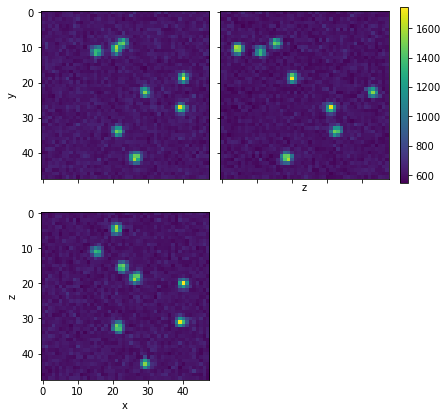

In [ ]:
_ = plot_3d_projections(xsim_noise, size=3)

In [ ]:
micro.noise(xsim,background).log_prob(xsim_noise).mean()

tensor(-5.3318, device='cuda:0', grad_fn=<MeanBackward0>)

In [ ]:
from decode_fish.funcs.dataset import EstimateBackground
# img = load_tiff_image('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//datasets/CodFish/smFISH_data_Titlow/msp300_smFISH_3.tif')
img = xsim_noise.cpu()
estimate_bg = EstimateBackground(smoothing_filter_size=5)
bg = estimate_bg(img)

In [ ]:
# export
def estimate_noise_scale(img, bg_est, percentile=99, plot=True):
    
    img = cpu(img)
    bg_est = cpu(bg_est)
    residual = np.clip(img - bg_est + bg_est.mean(), img.min(), 1e10)
    fit_vals = residual[residual < np.percentile(residual, percentile)]
    fit_alpha, fit_loc, fit_beta=stats.gamma.fit(fit_vals, floc=0)   

    if plot:
        _ = plt.hist(fit_vals,bins=np.linspace(fit_vals.min(),fit_vals.max(), 51),  histtype ='step',label='data', density=True)
        x = np.linspace(fit_vals.min(),fit_vals.max(),101)
        y = stats.gamma.pdf(x, fit_alpha, fit_loc, fit_beta)
        plt.plot(x, y, label='Fit')
        plt.legend()
        
    return fit_beta

4.800549444184133

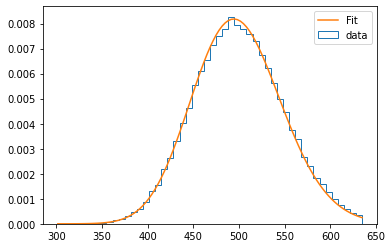

In [ ]:
estimate_noise_scale(img, bg, 99)

In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_evaluation.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 13_train.ipynb.
Converted 15_fit_psf.ipynb.
Converted 16_visualization.ipynb.
Converted 17_eval_routines.ipynb.
Converted 18_predict_funcs.ipynb.
Converted index.ipynb.
